# 2D ERT modeling and inversion
## This one tries to copy the deposit shape and do a better image of the geothermal plume


I'll try to add the geothermal plume as a diffusing body, meanwhile I'll keep the plume the same as the simple model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

print(pg.Report())


--------------------------------------------------------------------------------
  Date: Tue Aug 29 12:57:32 2023 -05

                OS : Linux
            CPU(s) : 8
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.6 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32)
  [GCC 12.3.0]

           pygimli : 1.4.3
            pgcore : 1.4.0
             numpy : 1.25.0
        matplotlib : 3.7.2
             scipy : 1.11.2
           IPython : 8.14.0
           pyvista : 0.41.1
--------------------------------------------------------------------------------


## Geometry definition

In [2]:
world = mt.createWorld(start=(-350, -250), end=(350, 0))

### Define geology below the deposit

Fault and inyection point definition

In [3]:
iPos = (-125, -200) #Inyection Point
fault = mt.createPolygon([iPos, (-150, -250)], isClosed= True)

Define Floresta and Cretacic

In [4]:
layer = mt.createPolygon([(-350, -150), iPos, (350, -150)], 
                         addNodes=100, interpolate='spline', isClosed=False)

Define Geometry

(<Axes: >, None)

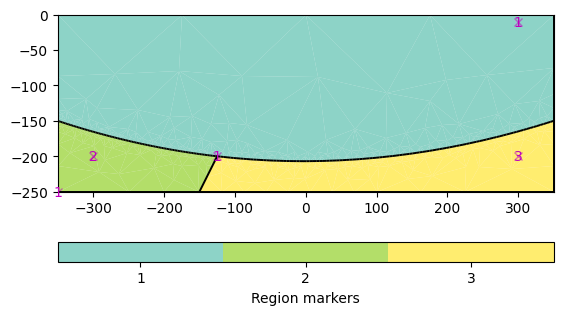

In [5]:
world += layer
world += fault

world.addRegionMarker((300, -10), marker=1)
world.addRegionMarker((-300, -200), marker=2)
world.addRegionMarker((300, -200), marker=3)

pg.show(world)

## Synthetic data generation
Create a Schlumberger ('slm') measuring scheme with 96 electrodes along a 700m line (-350 to 350)


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fc37e228b80>)

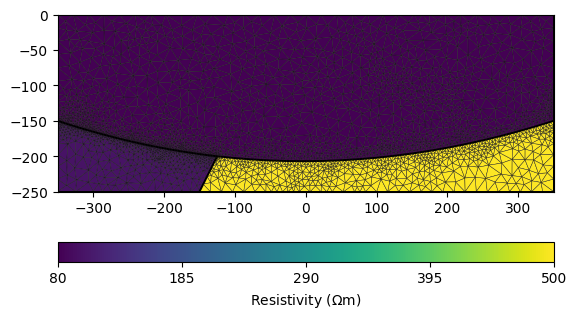

In [6]:
scheme = ert.createData(elecs=np.linspace(start=-350, stop=350, num=96),
                           schemeName='slm')

mesh = mt.createMesh(world, quality = 34, area = 200)

for p in scheme.sensors():
    world.createNode(p)
    world.createNode(p - [0, 0.1])

rhomap = [[1, 80.],
          [2, 100.],
          [3, 500.]]

pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

### Define diffusive fluid

Mesh:  Mesh: Nodes: 2334 Cells: 4535 Boundaries: 6868
Assembling time:  0.0799007
Solving time:  0.187982699


/home/ubuntu_jc/anaconda3/envs/pg/lib/python3.10/site-packages/pygimli/viewer/mpl/meshview.py:1001: UserWarning: linewidths is ignored by contourf
  gci = ax.tricontourf(x, y, triangles, z,


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fc37c3e0fa0>)

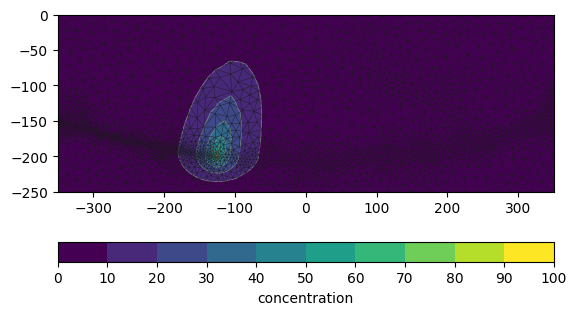

In [7]:
diff = pg.solver.cellValues(mesh, {2: pg.solver.createAnisotropyMatrix(0.1, 0.1, 0.0),
                                   3: pg.solver.createAnisotropyMatrix(0.1, 0.1, 0.0),
                                   1: pg.solver.createAnisotropyMatrix(1, 100, 20.0*np.pi/180)}
                                   )
iPosID = mesh.findNearestNode(iPos)

# stationary solution 
Cond = pg.solver.solve(mesh, a=diff,
                    bc={'Dirichlet': {'-1': 0.0, '-2': 0.0}, 'Neumann': {'-1': -1},
                        'Node':[iPosID, 100]}, verbose=True)

pg.show(mesh, Cond, label='concentration', showMesh=True, 
        cMin=0, cMax=100,  nCols=10, nLevs=11, linewidths=0.5)

Simulate resistivity based on the concentration of the fluid

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fc36f9f1120>)

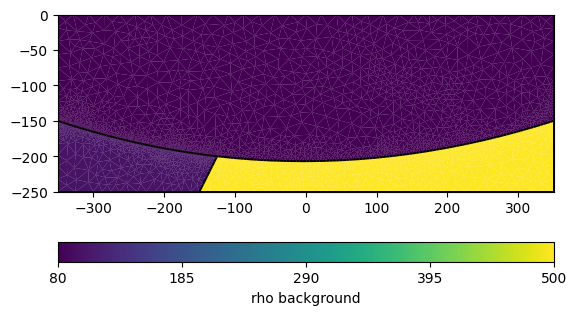

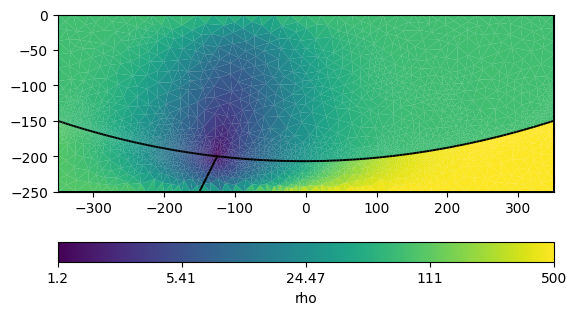

In [8]:
# Background rho0
rhoMin = 1
rhoMax = 100
rho0 = pg.solver.cellValues(mesh, {1: 80,
                                   2: 100,
                                   3: 500}
                                   )

pg.show(mesh, rho0, label='rho background')
Cond = pg.interpolate(mesh, Cond, mesh.cellCenters())
Cond[Cond < 0] = 0

# add anomal resistivity as linear function from rhoMin to rhoMax depending on concentration
rho = 1/(1/np.array(rho0) + 1/(rhoMin)*(Cond/100))

pg.show(mesh, rho, label='rho', logScale=True)

**Need to add this this plume to the ERT simulation, it's pending.**

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 3% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [9]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=3,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

ModellingBase::setMesh() copying new mesh ... Found datafile: 96 electrodes
Found: 96 free-electrodes
rMin = 3.68421, rMax = 1400
NGauLeg + NGauLag for inverse Fouriertransformation: 15 + 4
Found non-Neumann domain
0.0326165 s
FOP updating mesh dependencies ... 2.2e-06 s
Calculating response for model: min = 80 max = 500
Allocating memory for primary potential...... 0.0139311

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.608579s
Response: min = 12.3164 max = 1346.8 mean = 100.349
Reciprocity rms(modelReciprocity) 29.1339%, max: 402.626%
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.03000011791012259 : 0.030545945358993198


29/08/23 - 12:57:35 - pyGIMLi - INFO - 1.4149682279395321 5650.237337133764
29/08/23 - 12:57:35 - pyGIMLi - INFO - Simulated data Data: Sensors: 96 data: 2209, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
29/08/23 - 12:57:35 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
29/08/23 - 12:57:35 - pyGIMLi - INFO - Simulated rhoa (min/max) 10.485048737099353 1220.590547589066
29/08/23 - 12:57:35 - pyGIMLi - INFO - Selected data noise %(min/max) 3.000011791012259 3.05459453589932


Filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



29/08/23 - 12:57:35 - pyGIMLi - INFO - Filtered rhoa (min/max) 10.485048737099353 1220.590547589066


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fc36f762710>)

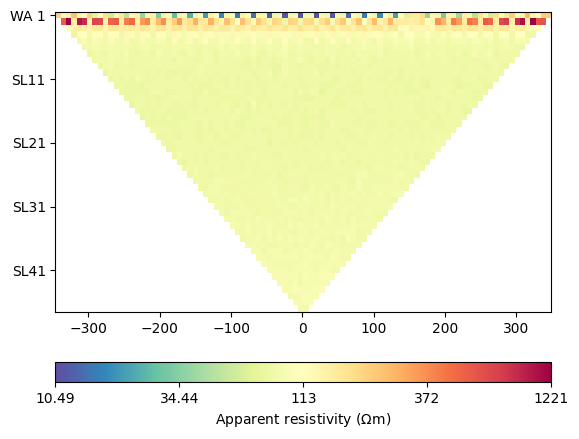

In [10]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('Forward_mod.dat')

# You can take a look at the data
ert.show(data)

Pseudosection is very poor with this new geometry definition, need to address this.

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [11]:
mgr = ert.ERTManager('Forward_mod.dat')

Run the inversion with the preset data. 
Since I set noise level to 3%, chi^2 target should be close to 0.9 or sighly above, also the regularization parameter should be in the range of 10 to 50 (I chose 30).



In [12]:
inv = mgr.invert(lam=30, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.9, significant=1)

29/08/23 - 12:57:36 - pyGIMLi - INFO - Found 2 regions.
29/08/23 - 12:57:36 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
29/08/23 - 12:57:36 - pyGIMLi - INFO - Found 2 regions.
29/08/23 - 12:57:36 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
29/08/23 - 12:57:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
29/08/23 - 12:57:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
29/08/23 - 12:57:36 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3861 Cells: 7264 Boundaries: 5676
29/08/23 - 12:57:36 - pyGIMLi - INFO - Use median(data values)=86.3352677681829
29/08/23 - 12:57:36 - pyGIMLi - INFO - Created startmodel from forward operator: 1519 [86.3352677681829,...,86.3352677681829]
29/08/23 - 12:57:36 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  1

Statistics:

  Input vertices: 199
  Input segments: 200
  Input holes: 0

  Mesh vertices: 1023
  Mesh triangles: 1816
  Mesh edges: 2838
  Mesh exterior boundary edges: 228
  Mesh interior boundary edges: 29
  Mesh subsegments (constrained edges): 257

min/max(dweight) = 32.7376/33.3332
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7fc36f6ffdd0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7fc36fc94810>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7fc36f6fd940>
min/max (data): 1

AssertionError: 
Items are not equal to 1 significant digits:
 ACTUAL: 57.20353270704247
 DESIRED: 0.9

Let the ERTManger show you the model of the last successful run and how it
fits the data. 
## Show data, model response, and model.



In [ ]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later